In [0]:
import numpy as np
import pickle
from itertools import permutations


class PointMaker:
    def __init__(self):
        self.points = []
        self.graph = []

    def path_solve(self, d):           #solve tsp dynamically given an adjacency matrix

        def memoize(f):                #memoize to generate path-cost dictionary
            memo_dict = {}

            def memo_func(*args):     
                if args not in memo_dict:
                    memo_dict[args] = f(*args)
                return memo_dict[args]

            memo_func.clear = lambda: memo_dict.clear()
            return memo_func

        @memoize
        def rec_path_solve(c, ts):            #Go through the TSP dynamically
            assert c not in ts
            if ts:
                vals = []
                for lc in ts:
                    aval = d[lc][c] + rec_path_solve(lc, ts - set([lc]))[0] #Recursion over the possible inputs 
                    vals.append((aval, lc))
                if (vals == []):
                    return (999, lc)
                val = min(vals)
                return val
            else:
                return (d[0][c], 0)

        best_tour = []
        c = 0
        cs = frozenset(range(1, len(d)))        #Generate frozen set for possible inputs from the graph
        while True:
            l, lc = rec_path_solve(c, cs)
            if lc == 0:
                break
            best_tour.append(lc)
            c = lc
            cs = cs - frozenset([lc])

        best_tour = tuple(reversed(best_tour))

        return best_tour

    def get_paths(self, d, s, t):                   #Get optimum path cost from point s to t
        opts = list(range(len(d)))
        perms = set(permutations(opts))
        minval = 999
        min_path = []
        flag = 1
        for perm in perms:
            sum_tour = 0

            for i in range(len(perm) - 1):
                sum_tour += d[perm[i]][perm[i + 1]]
                if (sum_tour > minval):
                    flag = 0
                    break
            if (flag):
                sum_tour +=d[perm[-1]][t]
                sum_tour += d[0][perm[s]]

                if (sum_tour < minval):
                    min_path = list(perm)
                    minval = sum_tour
            else:
                continue
        return min_path  # , minval    #Return the optimum path

    def get_distance(self, point1, point2):       #Get the Eucledian distance from two coordinates
        sums = 0
        for x in range(len(point1)):
            sums += ((point1[x] - point2[x]) ** 2)
        distance = np.sqrt(sums)
        return distance

    def calculate_graph(self, points): #calculate the adjacency matrix given the points
        adj_matrix = []
        for i, point1 in enumerate(points):
            row = []
            for j, point2 in enumerate(points):
                distance = self.get_distance(point1, point2)
                row.append(distance)
            adj_matrix.append(row)
        return np.array(adj_matrix)


    def generate_points(self, batch_size, number, size): #generate points and calculate paths from those points
        batches = []
        graphs = []
        paths = []
        for _ in range(batch_size):
            points = np.random.rand(number, size)        # Generate random points 
            batches.append(np.array(points))          
            graph = self.calculate_graph(points)         # calculate the adjacency matrices
            graphs.append(graph)
            path = list(self.get_paths(graph, 0, number-1)) #get the optimump aths from initial points to end points of the graph
            paths.append(path)
        return batches, paths




In [0]:
!git clone https://github.com/aurelienbibaut/Actor_CriticPointer_Network-TSP.git

In [0]:
cd Actor_CriticPointer_Network-TSP/

In [0]:
import tensorflow as tf
import numpy as np
import tsp_env
hidden_size = 128
embedding_size = 128
max_time_steps = 5; input_size = 2;
batch_size = 256
initialization_stddev = 0.1

tf.placeholder - allocates memory of tensor for later use

W_embed - initializes the weights of the size of inputs with normal randomization

einsum does a matrix multiplication to embed the inputs like this:

$einsum('ij,jk->ik', m0, m1)$    #output[i,k] = $sum_j m0[i,j] * m1[j, k]$


In [0]:
enc_inputs = tf.placeholder(tf.float32, [batch_size, max_time_steps, input_size])
W_embed = tf.Variable(tf.random_normal([embedding_size, input_size],
                                       stddev=initialization_stddev))
embedded_inputs = tf.einsum('kl,itl->itk', W_embed, enc_inputs)

#Encoding 
The Encoder takes the input sequence and maps it into a higher dimensional space (n-dimensional vector). That abstract vector is fed into the Decoder which turns it into an output sequence. The output sequence can be in another language, symbols, a copy of the input, etc.

In [0]:
with tf.variable_scope("encoder"):
    enc_rnn_cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    enc_outputs, enc_final_state = tf.nn.dynamic_rnn(cell=enc_rnn_cell, 
                                                     inputs=embedded_inputs,
                                                     dtype=tf.float32)

#Attention

Attention for Pointer networks is uses so the decoder can look back and forwards in the input. Therefore, it has access to encoder states from each step, not just the last one.

The mask is a preset distribution of weights

In [0]:
def attention_mask(W_ref, W_q, v, enc_outputs, query, already_played_actions=None, 
                   already_played_penalty=1e6):
    with tf.variable_scope("attention_mask"):
        u_i0s = tf.einsum('kl,itl->itk', W_ref, enc_outputs)
        u_i1s = tf.expand_dims(tf.einsum('kl,il->ik', W_q, query), 1)
        u_is = tf.einsum('k,itk->it', v, tf.tanh(u_i0s + u_i1s)) - already_played_penalty * already_played_actions
        return u_is, tf.nn.softmax(u_is)

#Decoding and Training



In [0]:
with tf.variable_scope("decoder"):
    decoder_cell = tf.nn.rnn_cell.LSTMCell(hidden_size)  #set an LSTM as decoding cell
    decoder_state = [enc_final_state]
    first_decoder_input = tf.tile(tf.Variable(tf.random_normal([1, embedding_size]), #get input from Latent space
                                      name='first_decoder_input'), [batch_size, 1])
    
    decoder_targets = tf.placeholder(dtype=tf.int32, shape=[batch_size, max_time_steps])  #get the training labels to compare LSTM outputs
    
    with tf.variable_scope("attention_weights", reuse=True):
        W_ref = tf.Variable(tf.random_normal([embedding_size, embedding_size], 
                                             stddev=initialization_stddev),
                           name='W_ref')
        W_q = tf.Variable(tf.random_normal([embedding_size, embedding_size],    
                                           stddev=initialization_stddev),
                         name='W_q')
        v = tf.Variable(tf.random_normal([embedding_size], stddev=initialization_stddev),
                        name='v')
    
    # Training chain
    loss = 0
    decoder_input = first_decoder_input
    decoder_state = enc_final_state
    already_played_actions = tf.zeros(shape=[batch_size, max_time_steps], dtype=tf.float32) # initialize states
    decoder_inputs = [decoder_input]
    for t in range(max_time_steps):
        dec_cell_output, decoder_state = decoder_cell(inputs=decoder_input, 
                                          state=decoder_state)
        attn_logits, _ = attention_mask(W_ref, W_q, v, enc_outputs, dec_cell_output,
                                        already_played_actions=already_played_actions,
                                        already_played_penalty=1e6)
        loss += tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(decoder_targets[:, t],
                                                                          depth=max_time_steps),
                                                        logits=attn_logits))
        loss_summary_sy = tf.summary.scalar('training_loss', loss)

        # Teacher forcing of the next input
        decoder_input = tf.einsum('itk,it->ik', embedded_inputs,
                                  tf.one_hot(decoder_targets[:, t], depth=max_time_steps))
        decoder_inputs.append(decoder_input)
        already_played_actions += tf.one_hot(decoder_targets[:, t], depth=max_time_steps)
    
    # Inference chain
    decoder_input = first_decoder_input
    decoder_state = enc_final_state
    decoder_outputs = []
    already_played_actions = tf.zeros(shape=[batch_size, max_time_steps], dtype=tf.float32)
    for t in range(max_time_steps):
        dec_cell_output, decoder_state = decoder_cell(inputs=decoder_input,
                                                      state=decoder_state)
        _, attn_mask = attention_mask(W_ref, W_q, v, enc_outputs, dec_cell_output,
                                      already_played_actions=already_played_actions,
                                      already_played_penalty=1e6)
        decoder_outputs.append(tf.argmax(attn_mask, axis=1))
        decoder_input = tf.einsum('itk,it->ik', embedded_inputs, attn_mask)
        already_played_actions += tf.one_hot(decoder_outputs[-1], depth=max_time_steps)

In [0]:
optimizer = tf.train.AdamOptimizer(1e-2) #use Adam optimizer with a learning rage of 0,001
train_op = optimizer.minimize(loss)

In [0]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
log_files_name = 'PointerNet-TSP5'
writer = tf.summary.FileWriter('/tmp/' + log_files_name, sess.graph) #Generate network summary

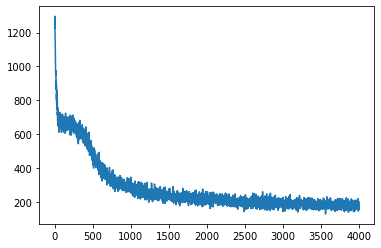

In [13]:
batch_size = 256
n_cities = 5
loss_vals = []
mean_approx_ratios = []
amax = 0


# Train the network over 4000 epochs
for i in range(4000):
    inputs_batch, labels_batch = pts.generate_points(batch_size,n_cities,2)
    #print(labels_batch)
    loss_summary, loss_val, _ = sess.run([loss_summary_sy, loss, train_op], 
                                         feed_dict={enc_inputs: inputs_batch, 
                                                        decoder_targets: labels_batch})
    loss_vals.append(loss_val)
    
    
    
    # Add training loss to tensorboard logs
    if i % 1000 == 0:
        writer.add_summary(loss_summary, i)
        writer.flush()
        print("Loss:",loss_vals[-1])
        
    # Test accuracy
    if i % 1000 == 0:
        envs = []
        inputs_list = []
        optimal_rewards = []
        optimal_tours = []
        # Generate and initialize a batch of environments
        inputs_batch, labels_batch = pts.generate_points(batch_size,n_cities,2)
          
        inputs_batch = np.array(inputs_batch)
        # Use the PointerNet on this test batch and get its predictions
        
        predicted_outputs = np.array(sess.run(decoder_outputs, 
                                              feed_dict={enc_inputs: inputs_batch})).T
        counts = 0
        tots = 0
        
        for i in range(10):
          print("P:",predicted_outputs[i], " R:", labels_batch[i],end=' ')
          if(np.all(predicted_outputs[i]==labels_batch[i])):
            print("Y")
          else:
            print("N")
        for i in range(batch_size):
          if(np.all(predicted_outputs[i]==labels_batch[i])):
            counts +=1
          tots +=1
        print(counts,tots,counts/tots, amax)
        if(counts/tots > amax):
          saver = tf.train.Saver()
          saver.save(sess, 'path_final_model9sm.model')
          amax= counts/tots
          print("saved",counts/tots)
        

# Plot the training losses
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_vals)


Loss over epoch plot

In [0]:
saver = tf.train.Saver()

In [0]:
class DynamicTSP():
  def __init__(self):
    self.points = points
    self.min_cost = 999

  def path_cost(self,path,graph):
    cost = 0
    for i in range(len(path)-1):
        cost+=graph[path[i]][path[i+1]]
    return cost

  def predict_cost(self,inputs_batch,graph):
    inputs_batch = [inputs_batch]*128
    inputs_batch = np.array(inputs_batch)
    predicted_outputs = np.array(sess.run(decoder_outputs, feed_dict={enc_inputs: inputs_batch})).T[0]
    cost = self.path_cost(predicted_outputs,graph)
    return cost

  def tsp_dp_solve(self,d): #Dynamic TSP solver
      def memoize(f):
          memo_dict = {}
          def memo_func(*args):
              if args not in memo_dict:
                  memo_dict[args] = f(*args)
              return memo_dict[args]
          memo_func.clear = lambda: memo_dict.clear()
          return memo_func

      @memoize
      def rec_tsp_solve(c, ts):
          if ts:
            vals = []
            for lc in ts:
              vals.append((d[lc][c] + rec_tsp_solve(lc, ts - set([lc]))[0], lc))
            val = min(vals)
            return val
          else:
            return (d[0][c], 0)

      best_tour = []
      c = 0
      cs = frozenset(range(1, len(d)))
      while True:
          l, lc = rec_tsp_solve(c, cs)
          if lc == 0:
              break
          best_tour.append(lc)
          c = lc
          cs = cs - frozenset([lc])

      best_tour = tuple(reversed(best_tour))

      return best_tour



In [0]:
class DynamicTSP2():
  def __init__(self,points,graph):
    self.points = points
    self.pred_cities = 5
    self.min_cost = 999
    self.cts = 0
    self.tots = 0

  def path_cost(self,path,graph):
    cost = 0
    for i in range(len(path)-1):
        cost+=graph[path[i]][path[i+1]]
    return cost

  def predict_cost(self,current,points,index,graph): # Predict the cost of the points
    inputs_batch = points[index]
    inputs_batch = [inputs_batch]*256
    inputs_batch = np.array(inputs_batch)
    #Generate prediction over 0 to n_cities
    predicted_outputs = np.array(sess.run(decoder_outputs, feed_dict={enc_inputs: inputs_batch})).T[0]
    pred_outs = []
    #reindex the path
    for x in predicted_outputs:
      pred_outs.append(index[x])
    #Get cost by joining the path
    cost = self.path_cost(pred_outs,graph)+graph[current][pred_outs[0]]+graph[current][pred_outs[-1]]
    return cost

  def tsp_dp_solve2(self,d):
        def memoize(f):             #memoize: generate path to cost map
            memo_dict = {}
            def memo_func(*args):
                if args not in memo_dict:
                    memo_dict[args] = f(*args)
                return memo_dict[args]
            memo_func.clear = lambda: memo_dict.clear()
            return memo_func

        @memoize
        def rec_path_solve(c, ts):
            assert c not in ts
            if ts:
                if (len(ts) == n_cities):
                    points = np.array(self.points)
                    indx = list(ts)
                    cost = self.predict_cost(c,points,indx, graph) #Generate cost prediction
                    first = list(ts)[0]
                    if (self.min_cost >cost+d[first][c]):
                      self.min_cost = cost+d[first][c]
                vals = []
                for lc in ts:
                    aval = d[lc][c] + rec_path_solve(lc, ts - set([lc]))[0]
                    self.tots +=1
                    if (aval < self.min_cost):        #Bound the check cost
                        self.cts+=1
                        vals.append((aval, lc))
                    
                if (vals == []):
                    return (999, lc)
                val = min(vals)
                return val
            else:
                return (d[0][c], 0)

        best_tour = []
        c = 0
        cs = frozenset(range(1, len(d))) #Set the possible points
        while True:
            l, lc = rec_path_solve(c, cs)
            if lc == 0:
                break
            best_tour.append(lc)
            c = lc
            cs = cs - frozenset([lc])
        best_tour = tuple(reversed(best_tour))

        return best_tour

In [32]:
import time 
t0 = time.time()
datas = pts.generate_points(1,10,2)      #Generate points
points = datas[0][0]
graph = pts.calculate_graph(points)      #Calculate graphs
print(datas)


t1 = time.time()
dtsp = DynamicTSP()                      #Test dynamic programming 1
out_real = dtsp.tsp_dp_solve(graph)       
print(out_real, dtsp.path_cost(out_real,graph))
t2  = time.time()
print("Dynamic algorithm time",t2-t1) 
dtsp2 = DynamicTSP2(points,graph)        #Test dynamic programming 2
out_pred = dtsp2.tsp_dp_solve2(graph)    
print(out_pred,dtsp.path_cost(out_real,graph))
t3 = time.time()
print("Dynamic algorithm with neural network time",t3-t2)
print()
print("Number of operations with predicted bound vs Number of operations without bound:")
print("                                  ",dtsp2.cts, "      ",dtsp2.tots)

([array([[0.95659873, 0.15649118],
       [0.73822391, 0.13313602],
       [0.15325601, 0.35116317],
       [0.60251944, 0.58686999],
       [0.28976751, 0.80131566],
       [0.06024383, 0.92342092],
       [0.62939841, 0.38233842],
       [0.66459971, 0.20725036],
       [0.68337566, 0.12588178],
       [0.15161645, 0.45579887]])], [[6, 3, 4, 5, 9, 2, 7, 8, 1]])
(6, 3, 4, 5, 9, 2, 7, 8, 1) 2.096639125235892
Dynamic algorithm time 0.018828630447387695
(1, 2, 3, 4, 5, 6, 7, 8, 9) 2.096639125235892
Dynamic algorithm with neural network time 8.760294675827026

Number of operations with predicted bound vs Number of operations without bound:
                                   2583        9225
